In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import torch.optim as optim
from tqdm import tqdm
import pickle
import seaborn as sns

from gnn_model import StationFlowGCN, StationFlowGAT
from train_gnn import(
    train_node_gnn_model,
    eval_node_gnn_model,
    get_metric_per_node_per_network,
    boxplot_node_metric,
    boxplot_node_metric_per_line,
    plot_true_predicted,
    plot_predicted_ape,
    MAPE_loss
)
from utils.station_network import StationNetworkSimul
from utils.data import get_degraded_network_loader

In [4]:
df_stations = pd.read_csv('plan du métro.csv')
df_stations = df_stations[~df_stations['vers Ligne'].isin(['\xa01', '\xa07', '\xa02', '\xa08', '\xa06'])]

df_pos = pd.read_csv("position gps des stations de métro.csv")

#Removing Malsesherbes RER Station
df_pos = df_pos.drop([151])

df_flow = pd.read_csv('passagers.csv')
df_flow['nombre'] = df_flow['nombre'].astype(float)
path_flows = df_flow[['de', 'vers', 'nombre']].to_dict('records')

test_network = StationNetworkSimul(df_stations=df_stations, df_pos=df_pos)

In [7]:
test_network.set_edges_weights()
test_network.set_nodes_traffic(path_flows=path_flows)

In [5]:
data_dir = "graph_dataset/"

train_degraded_graphs = []
dev_degraded_graphs = []
test_degraded_graphs = []

train_test_ratio = 0.9
dev_train_ratio = 0.1

for i in range(1,11):
    folder_path = os.path.join(data_dir, f'delete_{i}')
    all_files = [file_path for file_path in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file_path))]
    degraded_graphs = []
    for file_path in all_files:
        with open(os.path.join(folder_path, file_path), 'rb') as f:
            new_net = pickle.load(f)
        degraded_graphs.append(new_net)
    
    train_split_idx = int(train_test_ratio*len(all_files))
    dev_split_idx = int(dev_train_ratio*train_split_idx)

    dev_degraded_graphs.extend(degraded_graphs[:dev_split_idx])
    train_degraded_graphs.extend(degraded_graphs[dev_split_idx:train_split_idx])
    test_degraded_graphs.extend(degraded_graphs[train_split_idx:])

## GCNConv Models

In [6]:
config = dict(
    epochs = 20,
    lr = 0.001,
    criterion = torch.nn.L1Loss(),
    metrics = dict(
        MAE=torch.nn.L1Loss(),
        MAPE=MAPE_loss()
    )
)

### Using node position as input

In [385]:
target_name = 'traffic'
node_feature_names=['x', 'y']

train_loader = get_degraded_network_loader(train_degraded_graphs, target_name=target_name, node_feature_names=node_feature_names, shuffle=True)
dev_loader = get_degraded_network_loader(dev_degraded_graphs, target_name=target_name, node_feature_names=node_feature_names, shuffle=True)
test_loader = get_degraded_network_loader(test_degraded_graphs, target_name=target_name, node_feature_names=node_feature_names, shuffle=True)

In [ ]:
input_dim = train_loader.dataset[0].x.shape[1]
output_dim = 1

nodes_gnn_model = StationFlowGCN(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
)

train_node_gnn_model(nodes_gnn_model, config, train_loader, dev_loader)


In [ ]:
test_metrics = eval_node_gnn_model(nodes_gnn_model, test_loader,config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics.items()]))

In [ ]:
# test_data = random.choice(test_loader.dataset)
test_data = test_loader.dataset[0]
x, edge_index = test_data.x, test_data.edge_index
output = nodes_gnn_model(x, edge_index)

actual_flows = test_data.y
predicted_flows = output.detach().squeeze(1)

plot_true_predicted(predicted_flows, actual_flows)
plot_predicted_ape(predicted_flows, actual_flows)


### Using node embedding as input

#### Initialized + updated during training

#####  Unweighted edges

In [7]:
target_name = 'traffic'

train_loader = get_degraded_network_loader(train_degraded_graphs, target_name=target_name, shuffle=True)
dev_loader = get_degraded_network_loader(dev_degraded_graphs, target_name=target_name, shuffle=True)
test_loader = get_degraded_network_loader(test_degraded_graphs, target_name=target_name, shuffle=True)

In [8]:
input_dim = 100
output_dim = 1

nodes_gnn_model = StationFlowGCN(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
    embeddings='initialized'
)

train_node_gnn_model(nodes_gnn_model, config, train_loader, dev_loader)


Epoch 0 - Train loss: 6189.369396047005 Eval: MAE: 3985.36865234375	MAPE: 0.2743932604789734

Epoch 1 - Train loss: 3956.954458806187 Eval: MAE: 3819.543701171875	MAPE: 0.2639123797416687

Epoch 2 - Train loss: 3820.5870913826457 Eval: MAE: 3693.4775390625	MAPE: 0.2486371099948883

Epoch 3 - Train loss: 3649.773340885108 Eval: MAE: 3522.281494140625	MAPE: 0.22481679916381836

Epoch 4 - Train loss: 3530.417567537859 Eval: MAE: 3423.36083984375	MAPE: 0.20911042392253876

Epoch 5 - Train loss: 3463.949305529843 Eval: MAE: 3411.560546875	MAPE: 0.20174705982208252

Epoch 6 - Train loss: 3429.1194909262995 Eval: MAE: 3379.774169921875	MAPE: 0.20764632523059845

Epoch 7 - Train loss: 3395.364540136256 Eval: MAE: 3306.784912109375	MAPE: 0.19264307618141174

Epoch 8 - Train loss: 3346.7306732611632 Eval: MAE: 3261.8564453125	MAPE: 0.18967655301094055

Epoch 9 - Train loss: 3314.273976402825 Eval: MAE: 3251.114990234375	MAPE: 0.18745172023773193

Epoch 10 - Train loss: 3302.6326094351675 Eval: 

In [9]:
test_metrics = eval_node_gnn_model(nodes_gnn_model, test_loader,config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics.items()]))

MAE: 3202.16845703125	MAPE: 0.16383454203605652


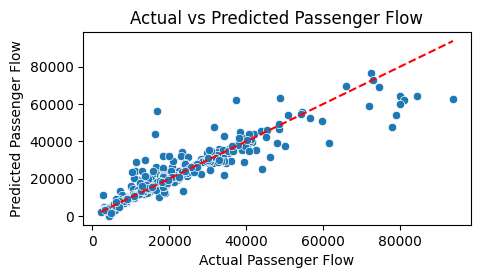

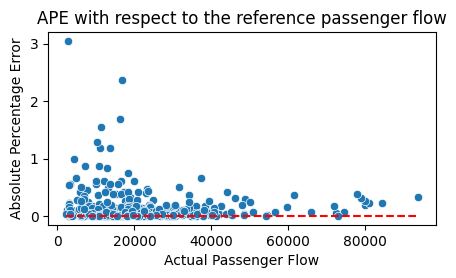

In [10]:
test_data = test_loader.dataset[0]
x, edge_index = test_data.x, test_data.edge_index
output = nodes_gnn_model(x, edge_index)

actual_flows = test_data.y
predicted_flows = output.detach().squeeze(1)

plot_true_predicted(predicted_flows, actual_flows)
plot_predicted_ape(predicted_flows, actual_flows)

##### Using edges weights (based on node position)

In [ ]:
target_name = 'traffic'
edge_feature_names = ['weight']

train_loader = get_degraded_network_loader(train_degraded_graphs, target_name=target_name, edge_feature_names=edge_feature_names, shuffle=True)
dev_loader = get_degraded_network_loader(dev_degraded_graphs, target_name=target_name, edge_feature_names=edge_feature_names, shuffle=True)
test_loader = get_degraded_network_loader(test_degraded_graphs, target_name=target_name, edge_feature_names=edge_feature_names, shuffle=True)

In [ ]:
input_dim = 100
output_dim = 1

nodes_gnn_model = StationFlowGCN(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
    embeddings='initialized'
)

train_node_gnn_model(nodes_gnn_model, config, train_loader, dev_loader)

In [ ]:
test_metrics = eval_node_gnn_model(nodes_gnn_model, test_loader,config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics.items()]))

In [295]:
metric = MAPE_loss(reduction='none')
df_ape_per_node_per_network = get_metric_per_node_per_network(nodes_gnn_model, test_loader, metric, test_network)

In [ ]:
boxplot_node_metric(df_ape_per_node_per_network, 46, test_network, 'APE')
plt.show()

In [ ]:
boxplot_node_metric_per_line(df_ape_per_node_per_network, '3bis', test_network, 'APE')
plt.show()

In [ ]:
test_data = test_loader.dataset[0]
x, edge_index = test_data.x, test_data.edge_index
output = nodes_gnn_model(x, edge_index)

actual_flows = test_data.y
predicted_flows = output.detach().squeeze(1)

plot_true_predicted(predicted_flows, actual_flows)
plot_predicted_ape(predicted_flows, actual_flows)

#### Using Node2Vec embeddings as input

In [14]:
from torch_geometric.nn import Node2Vec

In [15]:
node_idx = torch.tensor([i for i in sorted(test_network.network_graph.nodes)], dtype=torch.int)
tensor_edges = torch.tensor([
    [edge[0] for edge in sorted(test_network.network_graph.edges)],
    [edge[1] for edge in sorted(test_network.network_graph.edges)]
    ], dtype=torch.long)
init_data_graph = Data(x=node_idx, edge_index=tensor_edges)

In [24]:
model_n2v = Node2Vec(
    init_data_graph.edge_index,
    embedding_dim=100,
    walks_per_node=10,
    walk_length=20,
    context_size=10,
    p=1.0,
    q=1.0,
    num_negative_samples=10,
)

In [25]:
loader_n2v = model_n2v.loader(batch_size=128, shuffle=True)
optimizer_n2v = optim.Adam(model_n2v.parameters(), lr=0.01)

In [26]:
model_n2v.train()
for pos_rw, neg_rw in loader_n2v:
    optimizer_n2v.zero_grad()
    loss = model_n2v.loss(pos_rw, neg_rw)
    loss.backward()
    optimizer_n2v.step()

In [ ]:
embeddings_n2v = model_n2v()
isinstance(embeddings_n2v, torch.Tensor)

In [ ]:
input_dim = 100
output_dim = 1

nodes_gnn_model = StationFlowGCN(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
    embeddings=embeddings_n2v,
    freeze=False
)

config = dict(
    epochs = 20,
    lr = 0.001,
    criterion = torch.nn.L1Loss(),
    metrics = dict(
        MAE=torch.nn.L1Loss(),
        MAPE=MAPE_loss()
    )
)

train_node_gnn_model(nodes_gnn_model, config, train_loader, dev_loader)

In [ ]:
test_metrics = eval_node_gnn_model(nodes_gnn_model, test_loader,config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics.items()]))

## GATConv Models

In [6]:
config = dict(
    epochs = 20,
    lr = 0.001,
    criterion = torch.nn.L1Loss(),
    metrics = dict(
        MAE=torch.nn.L1Loss(),
        MAPE=MAPE_loss()
    )
)

### Using node embedding as input

#### Initialized + updated during training

#####  Unweighted edges

In [7]:
target_name = 'traffic'

train_loader = get_degraded_network_loader(train_degraded_graphs, target_name=target_name, shuffle=True)
dev_loader = get_degraded_network_loader(dev_degraded_graphs, target_name=target_name, shuffle=True)
test_loader = get_degraded_network_loader(test_degraded_graphs, target_name=target_name, shuffle=True)

In [9]:
input_dim = 100
output_dim = 1

nodes_gnn_model = StationFlowGAT(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
    embeddings='initialized',
    num_heads=4
)

train_node_gnn_model(nodes_gnn_model, config, train_loader, dev_loader)


Epoch 0 - Train loss: 7030.517904706476 Eval: MAE: 3649.0244140625	MAPE: 0.25127583742141724

Epoch 1 - Train loss: 3687.160537792043 Eval: MAE: 3073.965087890625	MAPE: 0.2039991021156311

Epoch 2 - Train loss: 2776.507885395068 Eval: MAE: 2539.18115234375	MAPE: 0.1680379956960678

Epoch 3 - Train loss: 2580.0284564122203 Eval: MAE: 2824.088623046875	MAPE: 0.18075577914714813

Epoch 4 - Train loss: 2547.1298881639236 Eval: MAE: 2317.178466796875	MAPE: 0.1644669771194458

Epoch 5 - Train loss: 2322.50491058205 Eval: MAE: 2246.217041015625	MAPE: 0.1629260927438736

Epoch 6 - Train loss: 2256.093822895068 Eval: MAE: 2223.396240234375	MAPE: 0.16339270770549774

Epoch 7 - Train loss: 2291.949731329606 Eval: MAE: 2182.92041015625	MAPE: 0.16147956252098083

Epoch 8 - Train loss: 2237.1892539652604 Eval: MAE: 2093.183349609375	MAPE: 0.15929195284843445

Epoch 9 - Train loss: 2178.4615539261517 Eval: MAE: 2213.553955078125	MAPE: 0.1627068668603897


KeyboardInterrupt: 

In [10]:
test_metrics = eval_node_gnn_model(nodes_gnn_model, test_loader,config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics.items()]))

MAE: 2298.255126953125	MAPE: 0.15389484167099


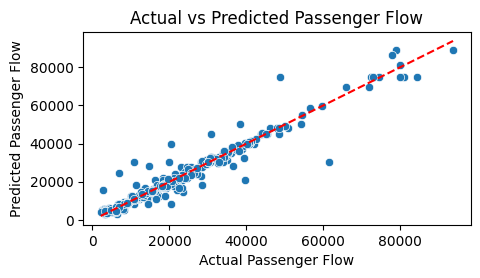

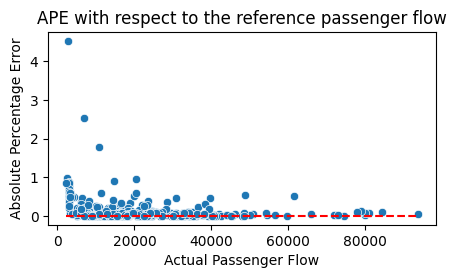

In [11]:
test_data = test_loader.dataset[0]
x, edge_index = test_data.x, test_data.edge_index
output = nodes_gnn_model(x, edge_index)

actual_flows = test_data.y
predicted_flows = output.detach().squeeze(1)

plot_true_predicted(predicted_flows, actual_flows)
plot_predicted_ape(predicted_flows, actual_flows)

c:\Users\tengo\Documents\Cours IAM - IAAA\IAM\Projet 3A\FlowForecasting\train_gnn.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_yticklabels((network_simul.network_graph.nodes[node_idx]['title'] for node_idx in df_boxplot_line.columns))


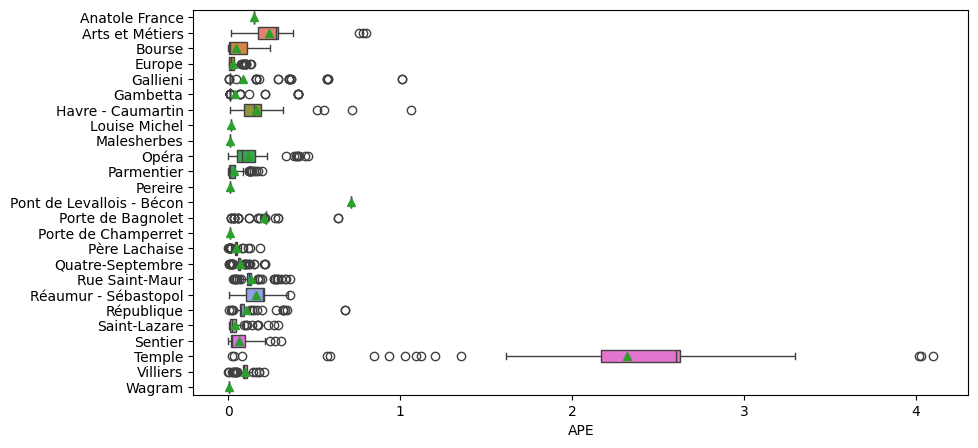

In [15]:
metric = MAPE_loss(reduction='none')
df_ape_per_node_per_network = get_metric_per_node_per_network(nodes_gnn_model, test_loader, metric, test_network)
boxplot_node_metric_per_line(df_ape_per_node_per_network, '3', test_network, 'APE')
plt.show()

c:\Users\tengo\Documents\Cours IAM - IAAA\IAM\Projet 3A\FlowForecasting\train_gnn.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_yticklabels((network_simul.network_graph.nodes[node_idx]['title'] for node_idx in df_boxplot_line.columns))


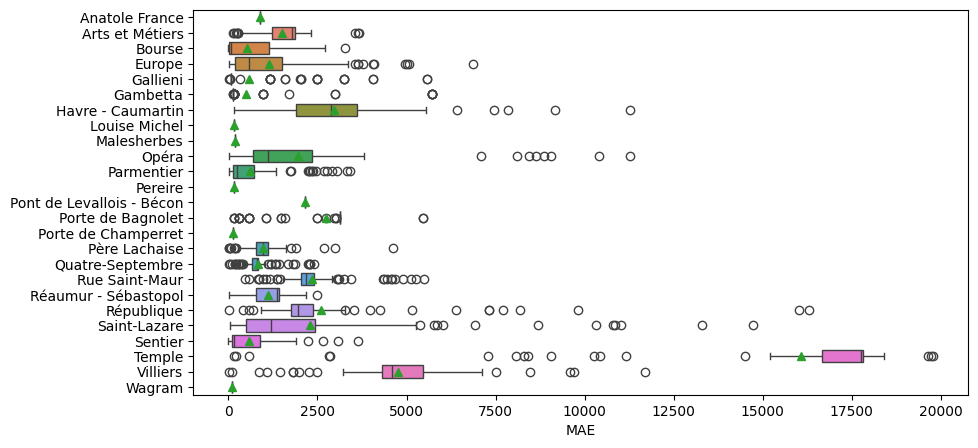

In [17]:
metric = torch.nn.L1Loss(reduction='none')
df_ape_per_node_per_network = get_metric_per_node_per_network(nodes_gnn_model, test_loader, metric, test_network)
boxplot_node_metric_per_line(df_ape_per_node_per_network, '3', test_network, 'MAE')
plt.show()

#####  Weighted edges (based on node position)

In [7]:
target_name = 'traffic'
edge_feature_names = ['weight']

train_loader = get_degraded_network_loader(train_degraded_graphs, target_name=target_name,edge_feature_names=edge_feature_names, shuffle=True)
dev_loader = get_degraded_network_loader(dev_degraded_graphs, target_name=target_name,edge_feature_names=edge_feature_names, shuffle=True)
test_loader = get_degraded_network_loader(test_degraded_graphs, target_name=target_name,edge_feature_names=edge_feature_names, shuffle=True)

In [9]:
input_dim = 100
output_dim = 1

nodes_gnn_model = StationFlowGAT(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
    embeddings='initialized',
    edge_dim=1
)

train_node_gnn_model(nodes_gnn_model, config, train_loader, dev_loader)


Epoch 0 - Train loss: 10357.318793852748 Eval: MAE: 7367.31982421875	MAPE: 0.4703351557254791

Epoch 1 - Train loss: 7200.273649821349 Eval: MAE: 6928.71826171875	MAPE: 0.43060749769210815

Epoch 2 - Train loss: 6785.110551156139 Eval: MAE: 6590.021484375	MAPE: 0.3971714377403259

Epoch 3 - Train loss: 6586.037007553317 Eval: MAE: 6397.455078125	MAPE: 0.37038496136665344

Epoch 4 - Train loss: 6327.246674596416 Eval: MAE: 6234.49609375	MAPE: 0.38002654910087585

Epoch 5 - Train loss: 6241.309717259701 Eval: MAE: 6281.0263671875	MAPE: 0.378950297832489

Epoch 6 - Train loss: 6229.358422735856 Eval: MAE: 6456.01611328125	MAPE: 0.4097054600715637

Epoch 7 - Train loss: 6004.364948580051 Eval: MAE: 5839.4111328125	MAPE: 0.3104637563228607

Epoch 8 - Train loss: 5883.274526876296 Eval: MAE: 5836.56201171875	MAPE: 0.30864933133125305

Epoch 9 - Train loss: 6979.523702467787 Eval: MAE: 6884.52001953125	MAPE: 0.42964571714401245

Epoch 10 - Train loss: 6864.782670875296 Eval: MAE: 6800.889648

KeyboardInterrupt: 

In [10]:
test_metrics = eval_node_gnn_model(nodes_gnn_model, test_loader,config)
print("\t".join([f"{metric_name}: {metric_value}" for metric_name, metric_value in test_metrics.items()]))

MAE: 6389.7001953125	MAPE: 0.3302774429321289


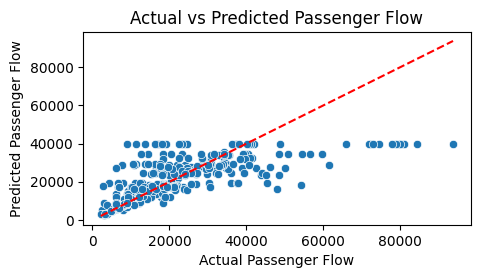

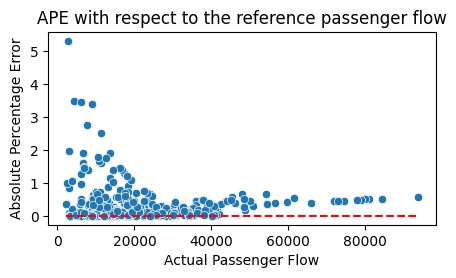

In [11]:
test_data = test_loader.dataset[0]
x, edge_index = test_data.x, test_data.edge_index
output = nodes_gnn_model(x, edge_index)

actual_flows = test_data.y
predicted_flows = output.detach().squeeze(1)

plot_true_predicted(predicted_flows, actual_flows)
plot_predicted_ape(predicted_flows, actual_flows)

In [12]:
metric = MAPE_loss(reduction='none')
df_ape_per_node_per_network = get_metric_per_node_per_network(nodes_gnn_model, test_loader, metric, test_network)

c:\Users\tengo\Documents\Cours IAM - IAAA\IAM\Projet 3A\FlowForecasting\train_gnn.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_yticklabels((network_simul.network_graph.nodes[node_idx]['title'] for node_idx in df_boxplot_line.columns))


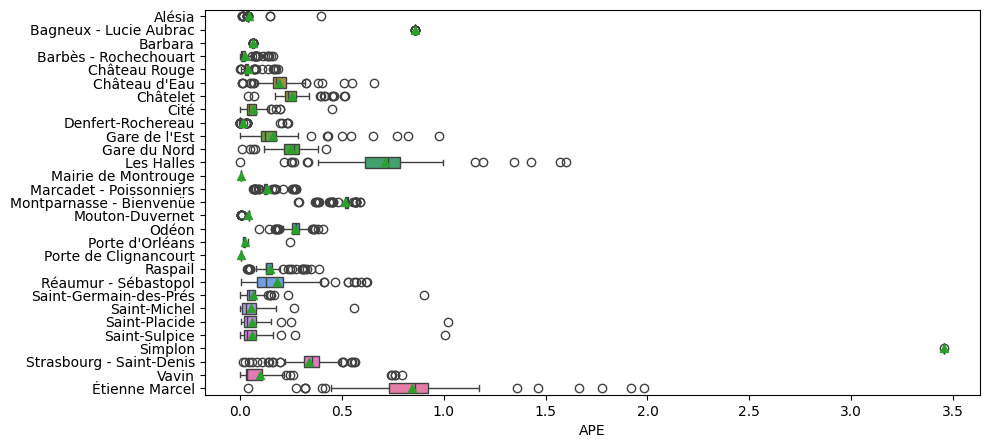

In [13]:
boxplot_node_metric_per_line(df_ape_per_node_per_network, '4', test_network, 'APE')
plt.show()

## Explainability

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer

In [ ]:
explainer = Explainer(
    model=nodes_gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

data = test_loader.dataset[0]
idx_chtl_4 = test_network.network_stations['Châtelet']['4']

explanation = explainer(data.x, data.edge_index, index=idx_chtl_4)
print(explanation.edge_mask)
print(explanation.node_mask)

In [ ]:
node_labels = nx.get_node_attributes(test_network.network_graph, 'title')
explanation.visualize_graph(node_labels=node_labels)